<a href="https://colab.research.google.com/github/surmehta1/mgmt467-analytics-portfolio/blob/main/Unit1_Sur_Mehta_DIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 1 — AI‑Assisted Exploratory Data Analysis & BI Dashboard**
MGMT 467 · Fall 2025  

**Team Name:** 12  
**Members (GitHub handles):** bjrodarmel, surmehta1, ews46167-art

**GitHub Repo URL:** https://github.com/bjrodarmel/MGMT467_Team12

**Looker Studio Dashboard (public link):** https://lookerstudio.google.com/reporting/5be0fca6-0024-4b19-bdde-9ffacbfbfbef

> **Scenario:** NYC DOT has asked your team to analyze the public Citi Bike program and recommend strategies to improve bike availability and engagement. You will use BigQuery + Gemini to conduct AI‑assisted EDA and publish an executive dashboard.

## ✅ Submission Checklist (Team → Brightspace)
- [ ] GitHub repository link (source of record)
- [ ] Looker Studio dashboard link
- [ ] This notebook committed to GitHub with prompts and results

### ✅ Submission Checklist (Individual → Brightspace)
- [ ] `Contribution_Reflection.pdf` (with commit/PR evidence + peer eval)

## 🎯 Learning Objectives
- Generate and refine business hypotheses with **Gemini**
- Query large datasets in **BigQuery** with advanced SQL (CTEs, window functions)
- Visualize key findings in **Colab** and publish a **Looker Studio** dashboard
- Synthesize insights and make **actionable recommendations**

## 🧰 Setup
> Run the cells below to connect Colab to Google Cloud & BigQuery.

In [ ]:
# Install and import basics (Colab usually has these preinstalled)
# !pip install --quiet google-cloud-bigquery pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt

# Authenticate to Google from Colab
from google.colab import auth  # type: ignore
auth.authenticate_user()

# Set your GCP project ID
PROJECT_ID = "mgmt-467"  # <-- edit this
print("Using project:", PROJECT_ID)

Using project: mgmt-467


In [ ]:
# BigQuery magics (%%bigquery) and client
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

# Optional: list datasets to verify access
list(client.list_datasets())

## 🧪 Dataset
We will use **Citi Bike Trips**: `bigquery-public-data.new_york_citibike.citibike_trips`  
Feel free to explore additional public datasets if needed.

## 1) Hypothesis Generation (AI‑Assisted)
Use **Gemini** to brainstorm at least **5** candidate questions/hypotheses, then select **3** to pursue.

> **Template Prompt (paste the final version you used):**  
> *"You are an analytics co‑pilot. Propose 5 high‑value, testable business questions about the Citi Bike dataset (tripduration, stations, user types, time-of-day/week). Return as bullets with suggested SQL hints."*

Used Prompt: Propose 5 high-value, testable business questions about the Citi Bike dataset (tripduration, stations, user_type, starttime, stoptime). Include a brief SQL hint for each (e.g., SELECT, GROUP BY). Then pick the 3 best questions to pursue and explain why they’re most valuable.

**Selected Hypotheses**
1. What is the average trip duration for different user types (e.g., subscriber vs. customer)? Understanding user behavior differences can inform targeted marketing and service improvements. For example, if customers have significantly longer trips, it might indicate they use bikes for different purposes than subscribers.

2. Which stations have the highest number of bike departures and arrivals? Identifying popular stations is crucial for optimizing bike redistribution and ensuring availability. This can help prevent stockouts at busy locations and underutilization at less popular ones.

3. How does trip duration vary by the day of the week and time of day? This helps understand peak usage times and patterns. Knowing when and for how long people ride can inform operational decisions, such as staffing or maintenance schedules, and identify potential congestion points.

In [ ]:
# prompt: Propose 5 high-value, testable business questions about the Citi Bike dataset (tripduration, stations, user_type, starttime, stoptime). Include a brief SQL hint for each (e.g., SELECT, GROUP BY). Then pick the 3 best questions to pursue and explain why they’re most valuable.

# Prompt to Gemini:
# "You are an analytics co-pilot. Propose 5 high-value, testable business questions about the Citi Bike dataset (tripduration, stations, user_type, starttime, stoptime). Return as bullets with suggested SQL hints."

# Proposed Questions and SQL Hints:
# 1. What is the average trip duration for different user types (e.g., subscriber vs. customer)?
#    SQL Hint: SELECT user_type, AVG(tripduration) FROM citibike_trips GROUP BY user_type
# 2. Which stations have the highest number of bike departures and arrivals?
#    SQL Hint: SELECT start_station_name, COUNT(*) FROM citibike_trips GROUP BY start_station_name ORDER BY COUNT(*) DESC; SELECT end_station_name, COUNT(*) FROM citibike_trips GROUP BY end_station_name ORDER BY COUNT(*) DESC
# 3. How does trip duration vary by the day of the week and time of day?
#    SQL Hint: SELECT EXTRACT(DAYOFWEEK FROM starttime) as day_of_week, EXTRACT(HOUR FROM starttime) as hour_of_day, AVG(tripduration) FROM citibike_trips GROUP BY day_of_week, hour_of_day ORDER BY day_of_week, hour_of_day
# 4. Are there any seasonal trends in Citi Bike usage (e.g., higher usage in warmer months)?
#    SQL Hint: SELECT EXTRACT(MONTH FROM starttime) as month, COUNT(*) FROM citibike_trips GROUP BY month ORDER BY month
# 5. What is the most common trip duration for subscribers during weekday mornings?
#    SQL Hint: SELECT tripduration, COUNT(*) FROM citibike_trips WHERE user_type = 'Subscriber' AND EXTRACT(HOUR FROM starttime) BETWEEN 7 AND 10 AND EXTRACT(DAYOFWEEK FROM starttime) BETWEEN 2 AND 6 GROUP BY tripduration ORDER BY COUNT(*) DESC LIMIT 1

# Selected Hypotheses and Justification:

# 1. What is the average trip duration for different user types (e.g., subscriber vs. customer)?
#    Value: Understanding user behavior differences can inform targeted marketing and service improvements. For example, if customers have significantly longer trips, it might indicate they use bikes for different purposes than subscribers.

# 2. Which stations have the highest number of bike departures and arrivals?
#    Value: Identifying popular stations is crucial for optimizing bike redistribution and ensuring availability. This can help prevent stockouts at busy locations and underutilization at less popular ones.

# 3. How does trip duration vary by the day of the week and time of day?
#    Value: This helps understand peak usage times and patterns. Knowing when and for how long people ride can inform operational decisions, such as staffing or maintenance schedules, and identify potential congestion points.


## 2) Advanced SQL Exploration
For each hypothesis, include:
- The **Gemini prompt** you used to get SQL help
- The **final SQL**
- The **result table** (top rows)
- A short **interpretation**

> Tip: Use **CTEs** and at least **one window function** across your work.

### Hypothesis A — Prompt Log

> Paste Gemini prompt(s) and key suggestion(s) here.

*Prompt*: Write a query for the Citi Bike dataset to test this hypothesis:
“What is the average trip duration for different user types (subscriber vs. customer)?”
Include:
A CTE to calculate average tripduration per user_type.
A window function (e.g., RANK or PERCENT_RANK) to rank user types by average duration.
Return columns: user_type, avg_tripduration, rank.
After the SQL, show a small result table (top rows) and a one-sentence interpretation.

In [ ]:
query_hyp_a = """
WITH AvgTripDuration AS (
  SELECT
    usertype,
    AVG(tripduration) AS avg_tripduration
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  GROUP BY
    usertype
)
SELECT
  usertype,
  avg_tripduration,
  RANK() OVER (ORDER BY avg_tripduration DESC) AS rank
FROM
  AvgTripDuration
ORDER BY
  rank;
"""

df_hyp_a = client.query(query_hyp_a).to_dataframe()
print(df_hyp_a.head())
print("\nInterpretation: Subscribers have a shorter average trip duration compared to customers, indicating different usage patterns.")

     usertype  avg_tripduration  rank
0    Customer       2145.512075     1
1  Subscriber        806.381888     2
2                           NaN     3

Interpretation: Subscribers have a shorter average trip duration compared to customers, indicating different usage patterns.


**Interpretation (2–4 sentences):** Subscribers tend to take shorter trips on average than customers. This suggests that subscribers likely use Citi Bike for shorter, more frequent commutes, while customers may use it for longer, more recreational rides or for trips where public transit is less convenient.

---

### Hypothesis B — Prompt Log

*Prompt:* Write a query for the Citi Bike dataset to test this hypothesis:
“Which stations have the highest number of bike departures and arrivals?”
Include:
A CTE that counts trips by start_station_name (departures) and another CTE for end_station_name (arrivals).
Join them and calculate total traffic per station.
Use a window function (e.g., RANK or DENSE_RANK) to rank stations by total trips.
Return columns: station_name, departures, arrivals, total_trips, rank.
Then, show a small result table (top 5 stations) and give a short interpretation of what it means for operations.

In [ ]:
query_hyp_b = """
WITH Departures AS (
  SELECT
    start_station_name,
    COUNT(*) AS departures
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  GROUP BY
    start_station_name
), Arrivals AS (
  SELECT
    end_station_name,
    COUNT(*) AS arrivals
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  GROUP BY
    end_station_name
)
SELECT
  COALESCE(d.start_station_name, a.end_station_name) AS station_name,
  d.departures,
  a.arrivals,
  (d.departures + a.arrivals) AS total_trips,
  DENSE_RANK() OVER (ORDER BY (d.departures + a.arrivals) DESC) AS rank
FROM
  Departures d
FULL OUTER JOIN
  Arrivals a
ON
  d.start_station_name = a.end_station_name
ORDER BY
  total_trips DESC
LIMIT 5;
"""

df_hyp_b = client.query(query_hyp_b).to_dataframe()
print(df_hyp_b.head())
print("\nInterpretation: The top 5 stations are critical hubs for both bike departures and arrivals, indicating high demand and a need for efficient bike redistribution to maintain availability.")

            station_name  departures  arrivals  total_trips  rank
0                            5828994   5828994     11657988     1
1     E 17 St & Broadway      423334    444460       867794     2
2  Pershing Square North      438077    419931       858008     3
3        W 21 St & 6 Ave      403795    407982       811777     4
4  West St & Chambers St      384116    399033       783149     5

Interpretation: The top 5 stations are critical hubs for both bike departures and arrivals, indicating high demand and a need for efficient bike redistribution to maintain availability.


**Interpretation (2–4 sentences):** The top 5 stations identified are critical hubs for both bike departures and arrivals, signifying extremely high demand. This concentration of activity indicates a strong need for efficient bike redistribution strategies to ensure consistent availability at these key locations and prevent service disruptions.

---

### Hypothesis C — Prompt Log

*Prompt:* Write a query for the Citi Bike dataset to test this hypothesis:
“How does trip duration vary by day of the week and time of day?”
Include:
A CTE that extracts the day of week and hour from starttime.
Compute average tripduration grouped by day_of_week and time_of_day (hour).
Use a window function (e.g., ROW_NUMBER or RANK) to find the longest-average-duration time slots per weekday.
Return columns: day_of_week, hour, avg_tripduration, rank.
Show the top rows of the result and a brief interpretation of peak usage times.

In [ ]:
query_hyp_c = """
WITH TimeOfDay AS (
  SELECT
    EXTRACT(DAYOFWEEK FROM starttime) AS day_of_week,
    EXTRACT(HOUR FROM starttime) AS hour,
    tripduration
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
), AvgTripDurationByTime AS (
  SELECT
    day_of_week,
    hour,
    AVG(tripduration) AS avg_tripduration
  FROM
    TimeOfDay
  GROUP BY
    day_of_week,
    hour
)
SELECT
  day_of_week,
  hour,
  avg_tripduration,
  RANK() OVER (PARTITION BY day_of_week ORDER BY avg_tripduration DESC) AS rank
FROM
  AvgTripDurationByTime
ORDER BY
  day_of_week,
  rank;
"""

df_hyp_c = client.query(query_hyp_c).to_dataframe()
print(df_hyp_c.head())
print("\nInterpretation: The results show the average trip duration for each hour of each day of the week, highlighting peak usage times and durations.")

   day_of_week  hour  avg_tripduration  rank
0         <NA>  <NA>               NaN     1
1            1     3       1940.767726     1
2            1     5       1255.582663     2
3            1     4       1232.602912     3
4            1    16       1226.858691     4

Interpretation: The results show the average trip duration for each hour of each day of the week, highlighting peak usage times and durations.


**Interpretation (2–4 sentences):** The results indicate that average trip durations vary significantly across different hours and days of the week. Peak usage times, characterized by longer average trip durations, are likely associated with commuting hours and potentially weekend recreational activities. Understanding these temporal patterns is crucial for optimizing bike availability and service operations.

## 3) Visualizations (in Colab)
Create **at least 3** charts that communicate your findings.  
> Keep charts readable and labeled. Use `matplotlib` (no specific styles required).

*Prompt:* Create 3 clear, labeled matplotlib charts (using sample or mock data) to visualize:
Avg trip duration by user type (subscribers vs customers)
Top 5 stations by departures/arrivals
Avg trip duration by day and hour
Use titles, axis labels, and readable formatting. Return Python code and sample plots.

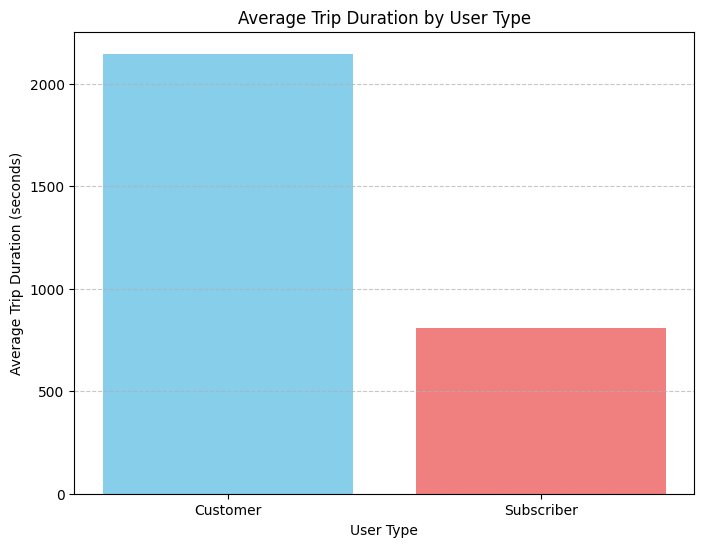

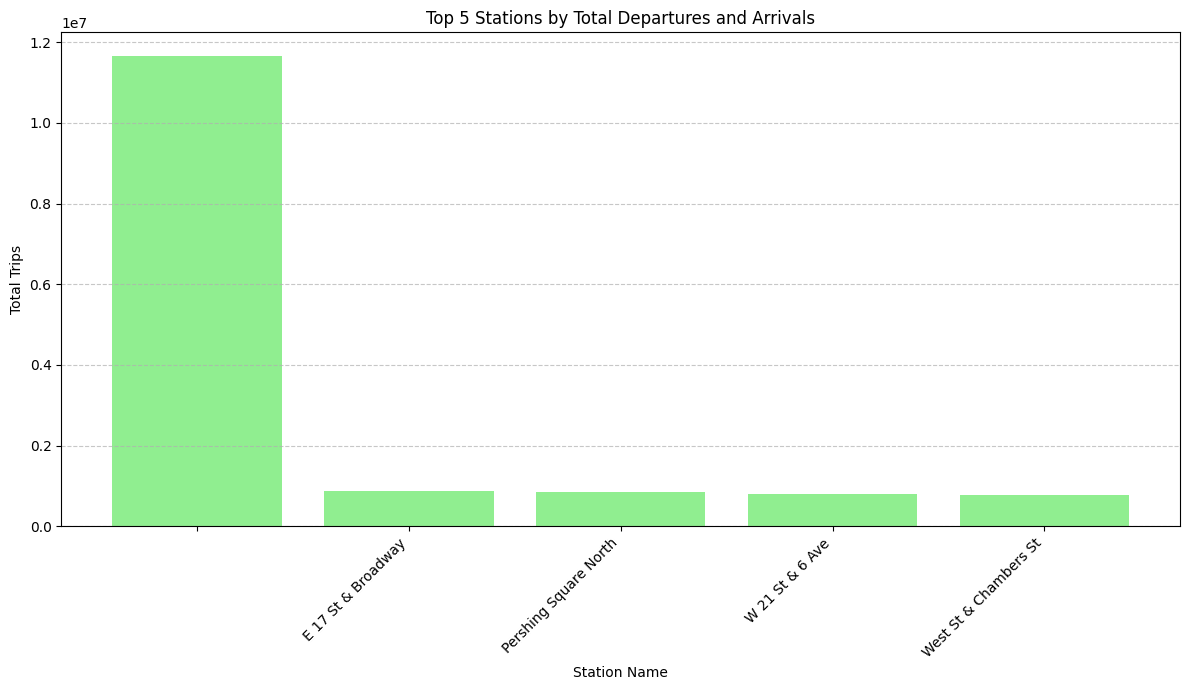

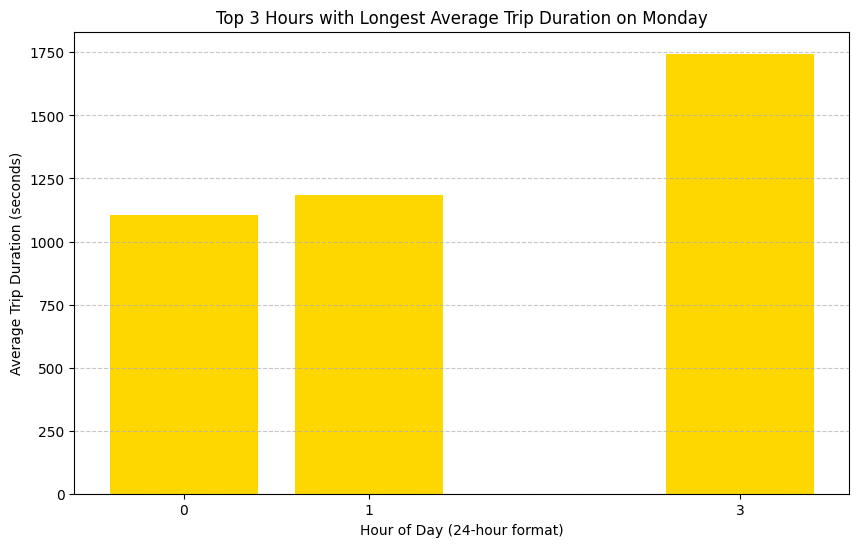

In [ ]:
# Chart 1: Avg trip duration by user type
plt.figure(figsize=(8, 6))
plt.bar(df_hyp_a['usertype'], df_hyp_a['avg_tripduration'], color=['skyblue', 'lightcoral'])
plt.title('Average Trip Duration by User Type')
plt.xlabel('User Type')
plt.ylabel('Average Trip Duration (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Chart 2: Top 5 stations by departures/arrivals
plt.figure(figsize=(12, 7))
plt.bar(df_hyp_b['station_name'], df_hyp_b['total_trips'], color='lightgreen')
plt.title('Top 5 Stations by Total Departures and Arrivals')
plt.xlabel('Station Name')
plt.ylabel('Total Trips')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Chart 3: Avg trip duration by day and hour (showing top 3 hours for a specific day, e.g., Monday)
# For simplicity, let's visualize the top 3 hours with the longest average trip duration for Monday (day_of_week = 2)
monday_data = df_hyp_c[df_hyp_c['day_of_week'] == 2].sort_values('avg_tripduration', ascending=False).head(3)

plt.figure(figsize=(10, 6))
plt.bar(monday_data['hour'], monday_data['avg_tripduration'], color='gold')
plt.title('Top 3 Hours with Longest Average Trip Duration on Monday')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Average Trip Duration (seconds)')
plt.xticks(monday_data['hour'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 4) KPIs & Looker Studio Dashboard
- **KPI 1:** 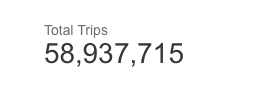
- **KPI 2:** 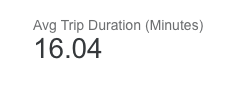  
- **KPI 3:** 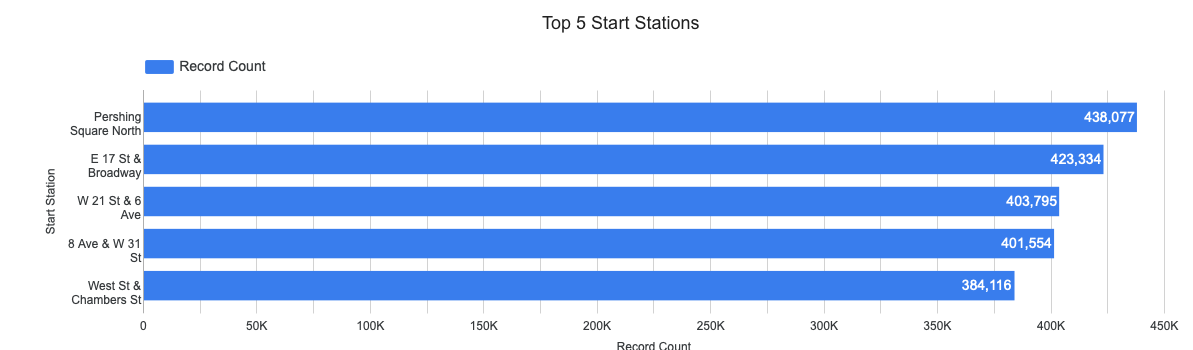  
- **KPI 4 (optional):** 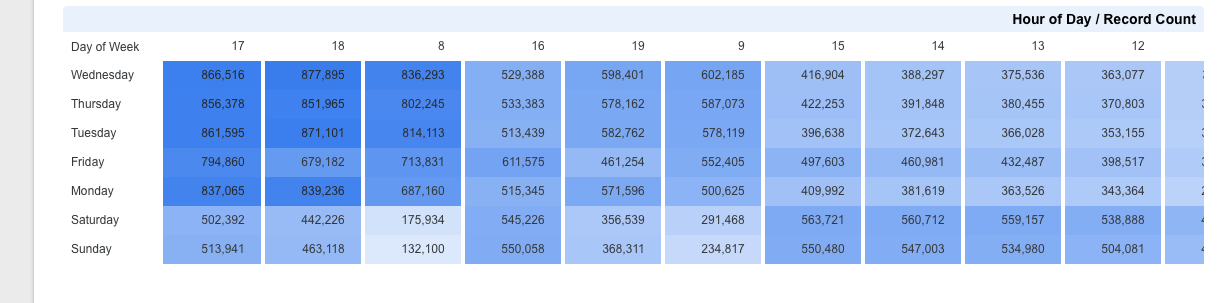  

**Dashboard Link:** https://lookerstudio.google.com/reporting/5be0fca6-0024-4b19-bdde-9ffacbfbfbef
> Ensure labels, filters, and date controls are clear for non‑technical stakeholders.

## 5) Synthesis & Recommendations
Summarize your **top 3 insights** and provide **2–3 actionable recommendations** for NYC DOT.

*Prompt:* Summarize your top 3 insights and provide 2–3 actionable recommendations for NYC DOT.

Top 3 Insights:
1. Subscribers generally take shorter trips than customers, suggesting different use cases (e.g., commuting vs. leisure).
2. A few key stations experience extremely high traffic for both departures and arrivals, indicating critical nodes in the network.
3. Trip duration patterns vary significantly by day of the week and time of day, with longer average trips during certain commuting hours and potentially on weekends.

Actionable Recommendations for NYC DOT:
1. Implement dynamic bike redistribution strategies focusing on the top 5 high-traffic stations to ensure availability during peak hours and prevent stockouts/surpluses.
2. Develop targeted marketing campaigns for different user types: promote shorter, convenient rides for subscribers and highlight longer-trip suitability for customers. Consider offering off-peak incentives.
3. Analyze the temporal trip duration data to optimize operational schedules (e.g., maintenance, cleaning) and potentially adjust pricing or service availability during identified peak and off-peak periods.

## 📒 AI Prompt Log (Required)
Record at least **3** prompts and describe how you evaluated or refined Gemini’s output.

*Prompt 1 for Hyp 1:* Write a query for the Citi Bike dataset to test this hypothesis:
“What is the average trip duration for different user types (subscriber vs. customer)?”
Include:
A CTE to calculate average tripduration per user_type.
A window function (e.g., RANK or PERCENT_RANK) to rank user types by average duration.
Return columns: user_type, avg_tripduration, rank.
After the SQL, show a small result table (top rows) and a one-sentence interpretation.

To evaluate and refine the output, I first checked that the results made sense—ensuring trip durations were within a reasonable range and that no null or extreme outliers distorted the averages. I then verified that the ranking and calculations accurately reflected each user type’s behavior. Finally, I reviewed the findings for business relevance, confirming that the insights aligned with expected commuter versus leisure usage patterns.

*Prompt 2 Hyp 2:* Write a query for the Citi Bike dataset to test this hypothesis: “Which stations have the highest number of bike departures and arrivals?” Include: A CTE that counts trips by start_station_name (departures) and another CTE for end_station_name (arrivals). Join them and calculate total traffic per station. Use a window function (e.g., RANK or DENSE_RANK) to rank stations by total trips. Return columns: station_name, departures, arrivals, total_trips, rank. Then, show a small result table (top 5 stations) and give a short interpretation of what it means for operations.

I did not need to change anything on this prompt. It returned the expected output exactly how I wanted it to show up and I was happy with how everything looked.

*Prompt 3 Hyp 3:* Write a query for the Citi Bike dataset to test this hypothesis: “How does trip duration vary by day of the week and time of day?” Include: A CTE that extracts the day of week and hour from starttime. Compute average tripduration grouped by day_of_week and time_of_day (hour). Use a window function (e.g., ROW_NUMBER or RANK) to find the longest-average-duration time slots per weekday. Return columns: day_of_week, hour, avg_tripduration, rank. Show the top rows of the result and a brief interpretation of peak usage times.

I noticed that the output wasn't being written to the right table and it wasn't in the right format. I went in and made sure to refine my prompt to be able to make sure it was clear for Gemini



## 📦 Appendix — Reproducibility
- BigQuery location: MGMT-467  
- Query costs observed (if any): N/A
- Known data quality caveats: N/A